## [Categorical Feature Encoding Challenge II in Kaggle](https://www.kaggle.com/c/cat-in-the-dat-ii)
ref: https://www.kaggle.com/abhishek/same-old-entity-embeddings<br>
https://www.kaggle.com/warkingleo2000/first-step-on-kaggle#Feature-Engineer

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
import random

In [ ]:
!unzip cat-in-the-dat-ii.zip

unzip:  cannot find or open cat-in-the-dat-ii.zip, cat-in-the-dat-ii.zip.zip or cat-in-the-dat-ii.zip.ZIP.


# **데이터 불러오기**

### df = pd.read_csv(filepath)

In [ ]:
# pandas의 read_csv를 call하여 data를 DataFrame 형태로 불러온다.
# .shape을 통해 데이터의 차원을 알 수 있다.
train_orig = pd.read_csv("/content/train.csv", index_col = 'id' )
test_orig = pd.read_csv("/content/test.csv", index_col = 'id' )
print(train_orig.shape, test_orig.shape)


(600000, 24) (400000, 23)


In [ ]:
# DataFrame의 head(N)를 call하면 맨 앞 N개의 데이터를 출력해준다.
train_orig.head()


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,777d1ac2c,3a7975e46,bc9cc2a94,NaN,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [ ]:
test_orig.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
id,,,,,,,,,,,,,,,,,,,,,,,
600000,0.0,0.0,0.0,F,Y,Blue,Polygon,Axolotl,Finland,Piano,52f6dd16c,147d704e4,8d857a0a1,ca9ad1d4b,fced9e114,3.0,Novice,Boiling Hot,f,U,oU,3.0,9.0
600001,0.0,0.0,0.0,F,Y,Red,Circle,Lion,Russia,Bassoon,691ebeae8,8653dcc2e,67a8d4ebb,060a21580,7ca8775da,1.0,Novice,Cold,n,N,NaN,2.0,8.0
600002,0.0,0.0,0.0,F,Y,Blue,Circle,Axolotl,Russia,Theremin,81f792c16,6cdda499e,69403e18c,165e81a00,5940334c9,1.0,Expert,Warm,i,N,DN,2.0,6.0
600003,1.0,0.0,0.0,F,N,Red,Polygon,Axolotl,Costa Rica,Bassoon,c9134205b,acbca4827,cb681246b,77d41330d,6fbdeefc8,1.0,Expert,Hot,m,B,AG,1.0,6.0
600004,0.0,0.0,1.0,F,Y,Red,Circle,NaN,Finland,Theremin,f0f100f57,6f800b9af,cd9feb5c6,2218d9dfe,2a27c8fde,1.0,Contributor,Lava Hot,o,J,DT,3.0,3.0


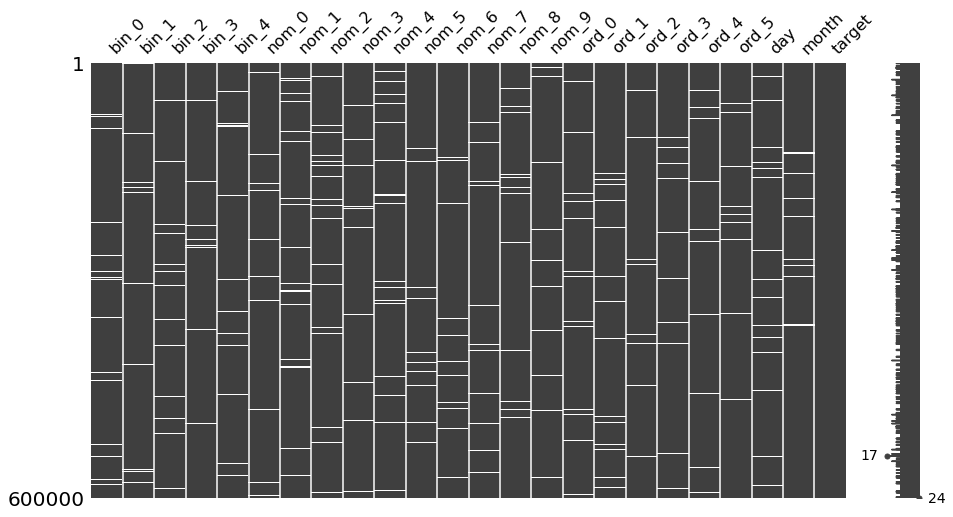

In [ ]:
# missingno 라이브러리를 통해 데이터의 결측치를 한 눈에 확인할 수 있다.
msno.matrix(train_orig,figsize = (15,8))


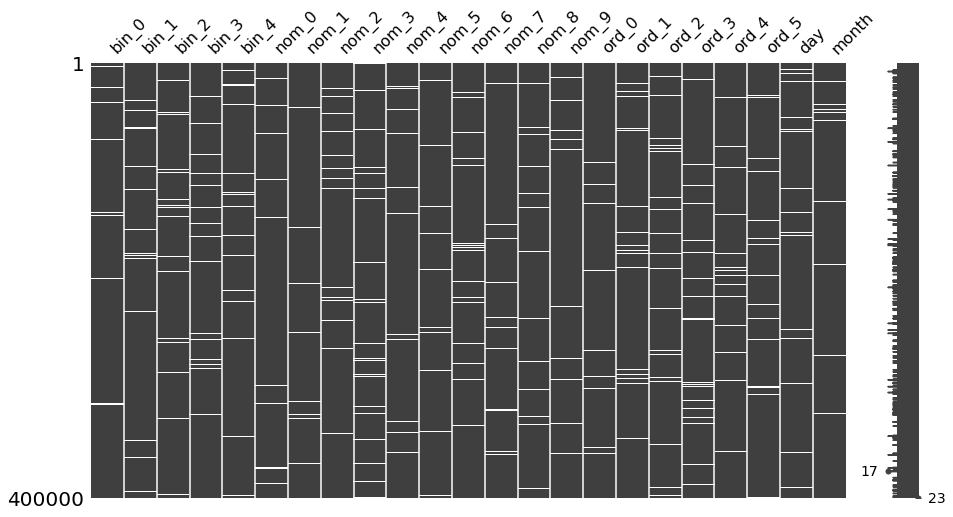

In [ ]:
msno.matrix(test_orig,figsize = (15,8))

Text(0.5, 1.0, 'Target Distribution')

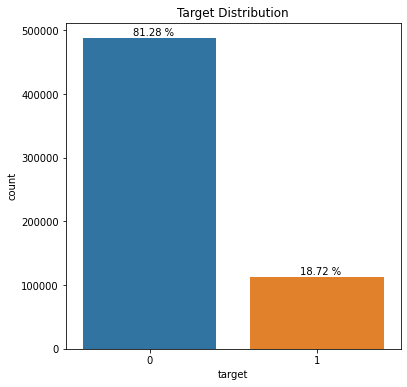

In [ ]:
plt.figure(figsize=(6,6))
ax = sns.countplot(train_orig.target)

height = sum([p.get_height() for p in ax.patches])
for p in ax.patches:
    ax.annotate(f'{100*p.get_height()/height:.2f} %', (p.get_x()+0.3, p.get_height()+5000), animated=True)
ax.set_title("Target Distribution")

In [ ]:
train_orig.columns

Index(['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'nom_0', 'nom_1', 'nom_2',
       'nom_3', 'nom_4', 'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_0',
       'ord_1', 'ord_2', 'ord_3', 'ord_4', 'ord_5', 'day', 'month', 'target'],
      dtype='object')

## Binary Data

Text(0.5, 0.98, 'Distribution over binary feature of train data')

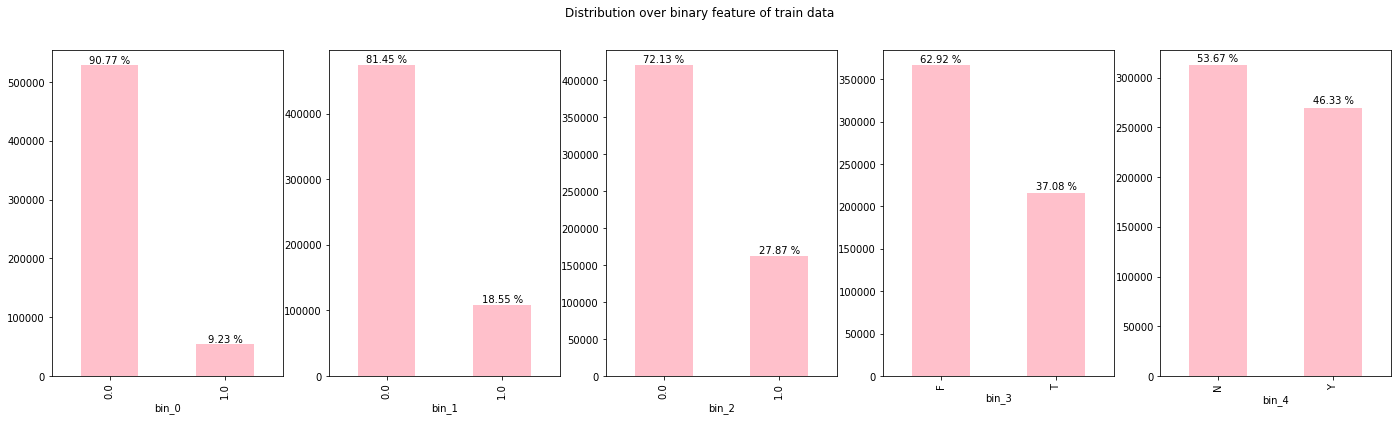

In [ ]:
bin_cols = [f'bin_{i}' for i in range(5)]

fig, ax = plt.subplots(1, 5, figsize=(24, 6))

for i, col in enumerate(bin_cols):
    ax0 = plt.subplot(1,5,i+1)
    train_orig[col].value_counts().plot.bar(color='pink')
    height = sum([p.get_height() for p in ax0.patches])
    for p in ax0.patches:
        ax0.text(p.get_x()+p.get_width()/2., p.get_height()+4000, f'{100*p.get_height()/height:.2f} %', ha='center')
    plt.xlabel(f'{col}')
plt.suptitle('Distribution over binary feature of train data')

## Nominal Data

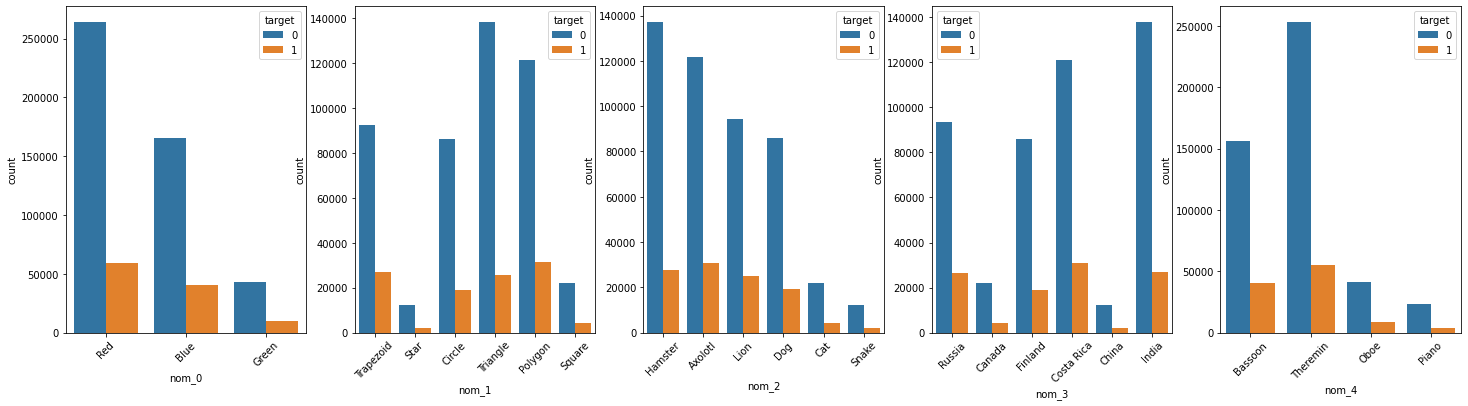

In [ ]:
nom_cols = [f'nom_{i}' for i in range(5)]
fig, ax = plt.subplots(1,5, figsize=(25, 6))
for i, col in enumerate(nom_cols):
    plt.subplot(1,5,i+1)
    sns.countplot(f'nom_{i}', hue='target', data= train_orig)
    plt.xticks(rotation=45)
plt.show()

In [ ]:
train_orig[['nom_8','nom_9']]

,nom_8,nom_9
id,,
0,0256c7a4b,02e7c8990
1,52ead350c,f37df64af
2,745b909d1,NaN
3,bdaa56dd1,f9d456e57
4,NaN,c5361037c
...,...,...
599995,158183c63,015c63324
599996,e9fde8fa8,a02ae6a63
599997,cccbca824,40f9610c1


In [ ]:
train_orig['nom_9'].unique()

array(['02e7c8990', 'f37df64af', nan, ..., 'd1e6704ed', 'b5f9881ba',
       '1538d82e9'], dtype=object)

## Ordinal Data

<Figure size 864x1872 with 0 Axes>

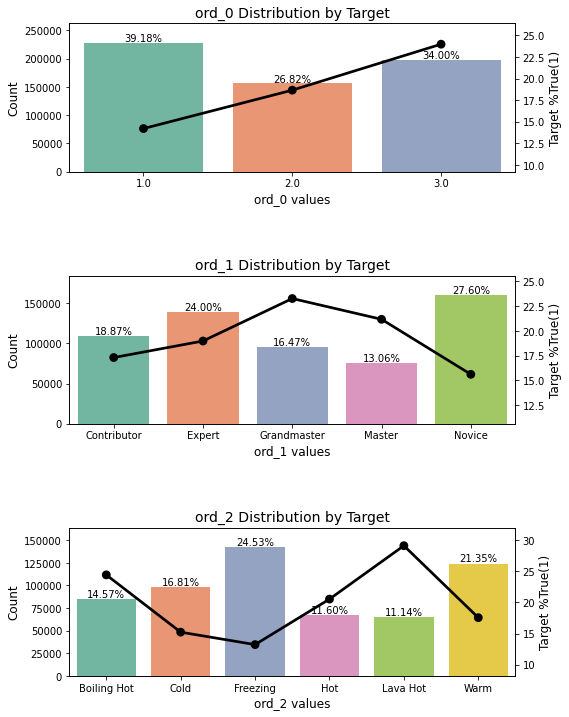

In [ ]:
ord_cols = [f'ord_{i}' for i in range(3)]
plt.figure(figsize=(12, 26)) 
fig, ax = plt.subplots(3,1,figsize=(8,12))

for i, col in enumerate(train_orig[ord_cols]): 
    tmp = pd.crosstab(train_orig[col], train_orig['target'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'No',1:'Yes'}, inplace=True)

    ax = plt.subplot(3,1,i+1)
    sns.countplot(x=col, data=train_orig, order=list(tmp[col].values) , palette='Set2') 
    ax.set_ylabel('Count', fontsize=12) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=14) # title label
    ax.set_xlabel(f'{col} values', fontsize=12) # x axis label

    gt = ax.twinx()
    gt = sns.pointplot(x=col, y='Yes', data=tmp,
                           order=list(tmp[col].values),
                           color='black', legend=False)
    gt.set_ylim(tmp['Yes'].min()-5,tmp['Yes'].max()*1.1)
    gt.set_ylabel("Target %True(1)", fontsize=12)
    sizes=[] # Get highest values in y
    total = sum([p.get_height() for p in ax.patches])
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                    height + 2000,
                    '{:1.2f}%'.format(height/total*100),
                    ha="center") 
    ax.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights

plt.subplots_adjust(hspace = 0.7, wspace=.3)
plt.show()

In [ ]:
# high cardinality의 데이터는 간단하게 출력
print("ord_3",train_orig['ord_3'].nunique())
print("ord_4",train_orig['ord_4'].nunique())
print("ord_5",train_orig['ord_5'].nunique())

ord_3 15
ord_4 26
ord_5 190


# **결측치 채우기**
1. 결측치가 있는 행 제거
2. 앞 뒤 값으로 채우기 
3. 범위 내 랜덤 값
4. 최다 빈도 값 
5. 평균 값
6. 새로운 값
7. Interpolate

In [ ]:
# 결측치가 있는 행 제거
#train_tmp = train_orig.dropna()

# 범위 내 랜덤 값 부여
def fillna_random(df):
    df_copy = df.copy()
    for col in df_copy.columns :
        unique = df_copy[col].dropna().unique()
        df_copy[col] = df_copy[col].apply(lambda x : random.choice(unique) if pd.isna(x) else x)
    return df_copy

# 최다 빈도 값 부여
def fillna_most_frequent(df):
    df_copy = df.copy()
    for col in df_copy.columns :
        mfv = df_copy[col].value_counts().index[0]
        df_copy[col] = df_copy[col].replace(np.nan,mfv)
    return df_copy

### One-Hot Encoding


1.   scikit-learn의 OneHotEncoder 사용
2.   pandas의 get_dummies 사용



In [ ]:
# 1. scikit-learn의 OneHotEncoder 사용
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder()
sample_feat = fillna_most_frequent(train_orig[['nom_1','nom_2']])
#sample_feat2 = fillna_random(train_orig[['nom_1','nom_2']])
after_ohe = OHE.fit_transform(sample_feat).toarray()
print(after_ohe.shape)
after_ohe[:5]

(600000, 12)


array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]])

In [ ]:
# 2. pandas의 get_dummies
pd.get_dummies(sample_feat)

,nom_1_Circle,nom_1_Polygon,nom_1_Square,nom_1_Star,nom_1_Trapezoid,nom_1_Triangle,nom_2_Axolotl,nom_2_Cat,nom_2_Dog,nom_2_Hamster,nom_2_Lion,nom_2_Snake
id,,,,,,,,,,,,
0,0,0,0,0,1,0,0,0,0,1,0,0
1,0,0,0,1,0,0,1,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0,1,0,0,0,0,1,0,0,0,0,0
599996,0,1,0,0,0,0,0,0,1,0,0,0
599997,1,0,0,0,0,0,1,0,0,0,0,0


### LabelEncoding
one-hot encoding의 단점인 차원의 저주를 해결하기 위해
Embedding을 사용한다. Embedding하기 전 label encoding을 해줘야함.

In [ ]:
from sklearn.preprocessing import LabelEncoder

test_orig['target'] = -1
data = pd.concat([train_orig,test_orig]).reset_index(drop = True)
data = fillna_random(data)
data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,Costa Rica,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,0.0,1.0,0.0,F,N,Red,Polygon,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,99e6b2dd2,3.0,Contributor,Freezing,n,P,eN,5.0,9.0,0
3,0.0,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57,1.0,Novice,Lava Hot,a,C,UV,3.0,3.0,0
4,0.0,0.0,0.0,T,N,Red,Triangle,Hamster,Costa Rica,Theremin,777d1ac2c,3a7975e46,bc9cc2a94,e6873698e,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [ ]:
# LabelEncoding
features = [x for x in train_orig.columns if x not in ["id","target","day","month"]]
for feat in features :
    le = LabelEncoder()
    data[feat] = le.fit_transform(data[feat])

data.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0,0,0,0,2,4,3,5,0,1059,1013,87,1,27,2,0,3,2,20,56,6.0,3.0,0
1,1,1,0,0,1,2,3,0,2,3,210,359,27,69,2112,2,2,5,4,23,150,7.0,7.0,0
2,0,1,0,0,0,2,1,3,0,0,860,694,90,102,1348,2,0,2,13,15,105,5.0,9.0,0
3,0,0,0,0,0,2,0,3,3,3,477,241,51,170,2167,0,4,4,0,2,80,3.0,3.0,0
4,0,0,0,1,0,2,5,3,2,3,556,361,182,203,1747,2,2,1,7,2,50,5.0,12.0,0


## Time features
![Time Features](https://miro.medium.com/max/343/1*70cevmU8wNggGJEdLam1lw.png)

datetime 데이터는 cyclic한 feature 이므로, 삼각함수를 이용해 encoding한다.

In [ ]:
# time과 관련된 데이터 encoding
time_cols = ['day','month']

for col in time_cols :
    if col == 'day' :
        data[col+'_sin'] = np.sin(2*np.pi*data[col]/7)
        data[col+'_cos'] = np.cos(2*np.pi*data[col]/7)
    
    else :
        data[col+'_sin'] = np.sin(2*np.pi*data[col]/12)
        data[col+'_cos'] = np.cos(2*np.pi*data[col]/12)

data = data.drop(columns = time_cols)
data.head()
    

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,target,day_sin,day_cos,month_sin,month_cos
0,0,0,0,0,0,2,4,3,5,0,1059,1013,87,1,27,2,0,3,2,20,56,0,-7.818315e-01,0.623490,1.000000e+00,6.123234e-17
1,1,1,0,0,1,2,3,0,2,3,210,359,27,69,2112,2,2,5,4,23,150,0,-2.449294e-16,1.000000,-5.000000e-01,-8.660254e-01
2,0,1,0,0,0,2,1,3,0,0,860,694,90,102,1348,2,0,2,13,15,105,0,-9.749279e-01,-0.222521,-1.000000e+00,-1.836970e-16
3,0,0,0,0,0,2,0,3,3,3,477,241,51,170,2167,0,4,4,0,2,80,0,4.338837e-01,-0.900969,1.000000e+00,6.123234e-17
4,0,0,0,1,0,2,5,3,2,3,556,361,182,203,1747,2,2,1,7,2,50,0,-9.749279e-01,-0.222521,-2.449294e-16,1.000000e+00


## Data Split

In [ ]:
# 합쳤던 train/test를 분리한다.
train = data[data.target != -1].reset_index(drop = True)
test = data[data.target == -1].reset_index(drop = True).drop('target',axis=1)

# train set을 source와 target으로 분리
y = train.target
x = train.drop('target',axis=1)

x.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day_sin,day_cos,month_sin,month_cos
0,0,0,0,0,0,2,4,3,5,0,1059,1013,87,1,27,2,0,3,2,20,56,-7.818315e-01,0.623490,1.000000e+00,6.123234e-17
1,1,1,0,0,1,2,3,0,2,3,210,359,27,69,2112,2,2,5,4,23,150,-2.449294e-16,1.000000,-5.000000e-01,-8.660254e-01
2,0,1,0,0,0,2,1,3,0,0,860,694,90,102,1348,2,0,2,13,15,105,-9.749279e-01,-0.222521,-1.000000e+00,-1.836970e-16
3,0,0,0,0,0,2,0,3,3,3,477,241,51,170,2167,0,4,4,0,2,80,4.338837e-01,-0.900969,1.000000e+00,6.123234e-17
4,0,0,0,1,0,2,5,3,2,3,556,361,182,203,1747,2,2,1,7,2,50,-9.749279e-01,-0.222521,-2.449294e-16,1.000000e+00


In [ ]:
from sklearn.model_selection import train_test_split

# train / validation set으로 split한다.
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size = 0.25,random_state = 77, stratify = y)

# categorical columns만 따로 분리.
normal_cols = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
cat_cols = [col for col in x.columns if col not in normal_cols]

def data_reshaping(data):
    
    data_copy = [data.loc[:, cat_cols].values[:, k] for k in range(data.loc[:, cat_cols].values.shape[1])]
    data_copy.append(data.loc[:, normal_cols].values)
   
    return data_copy

x_train = data_reshaping(x_train)
x_val = data_reshaping(x_val)
test = data_reshaping(test)

In [ ]:
len(x_train)

17

## Modeling

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

from sklearn import metrics

In [ ]:
def create_model(data, catcols):    
    inputs = []
    outputs = []
    for c in catcols:
        inp = layers.Input(shape=(1,))
        num_unique_values = int(data[c].nunique())
        embed_dim = int(min(np.ceil((num_unique_values)/2), 50))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(0.3)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        outputs.append(out)
        inputs.append(inp)
    normal = layers.Input(shape=(9, ))
    inputs.append(normal)
    outputs.append(normal)

    # 모델 쌓기
    x = layers.Concatenate(axis = -1)(outputs)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(300, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    
    x = layers.Dense(300, activation = "relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)

    y = layers.Dense(2,activation = 'softmax')(x)

    model = Model(inputs=inputs, outputs=y)
    return model

In [ ]:
K.clear_session()

# 모델 생성 후 컴파일
model = create_model(x,cat_cols)
model.compile(loss = 'binary_crossentropy',optimizer = 'adam', metrics = [tf.keras.metrics.AUC()])

# 콜백함수 지정
# callbacks.EarlyStopping - 학습이 진전되지 않으면 훈련은 종료한다
# callbacks.ReduceLROnPlateau - 학습 시 metric이 증가하지 않으면 learning rate를 감소시킨다.
# callbacks.ModelCheckpoint - 학습 중간중간 model weight를 저장한다
es = callbacks.EarlyStopping(monitor='val_auc',min_delta=0.001, patience=5,verbose = 1, mode = 'max', baseline = None,restore_best_weights = True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_auc',factor = 0.5,verbose = 1, mode = 'max')


In [ ]:
# 학습 시작
history = model.fit(x_train, utils.to_categorical(y_train),validation_data = (x_val, utils.to_categorical(y_val)),verbose = 1, batch_size = 1024,
                    callbacks=[es,rlr], epochs = 10)

Epoch 1/10
440/440 [==============================] - 35s 71ms/step - loss: 0.5705 - auc: 0.7895 - val_loss: 0.4250 - val_auc: 0.8917
Epoch 2/10
440/440 [==============================] - 30s 69ms/step - loss: 0.4154 - auc: 0.8911 - val_loss: 0.4056 - val_auc: 0.8968
Epoch 3/10
440/440 [==============================] - 30s 68ms/step - loss: 0.4070 - auc: 0.8956 - val_loss: 0.4045 - val_auc: 0.8970
Epoch 4/10
440/440 [==============================] - 31s 69ms/step - loss: 0.4036 - auc: 0.8974 - val_loss: 0.4063 - val_auc: 0.8971
Epoch 5/10
440/440 [==============================] - 31s 70ms/step - loss: 0.3979 - auc: 0.9003 - val_loss: 0.4073 - val_auc: 0.8962
Epoch 6/10
440/440 [==============================] - 31s 70ms/step - loss: 0.3929 - auc: 0.9027 - val_loss: 0.4077 - val_auc: 0.8953
Epoch 7/10
440/440 [==============================] - 31s 71ms/step - loss: 0.3868 - auc: 0.9057 - val_loss: 0.4118 - val_auc: 0.8941
Restoring model weights from the end of the best epoch.
Epoch 

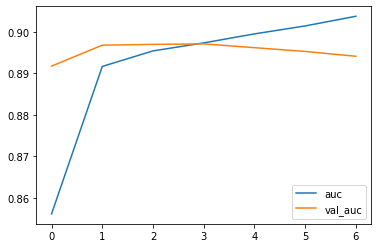

In [ ]:
# auc graph
auc = history.history['auc']
val_auc = history.history['val_auc']
sns.lineplot(x = range(len(auc)),y = auc)
sns.lineplot(x = range(len(val_auc)),y = val_auc)
plt.legend(['auc','val_auc'])

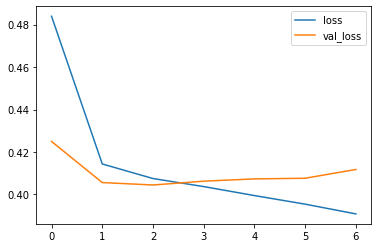

In [ ]:
# loss graph
loss = history.history['loss']
val_loss = history.history['val_loss']
sns.lineplot(x = range(len(loss)),y = loss)
sns.lineplot(x = range(len(val_loss)),y = val_loss)
plt.legend(['loss','val_loss'])

In [ ]:
# best model load
#model.load_weights('./checkpoint')
preds = model.predict(test)
preds

array([[0.96239936, 0.03760066],
       [0.79558223, 0.20441778],
       [0.9761209 , 0.02387913],
       ...,
       [0.615863  , 0.38413697],
       [0.85133916, 0.14866084],
       [0.9524675 , 0.04753249]], dtype=float32)

In [ ]:
# submission 파일 생성
submission = pd.read_csv('/content/sample_submission.csv')
submission.target = preds[:, 1]
submission.to_csv('/content/submission.csv', index=False)
submission.head()

,id,target
0,600000,0.037601
1,600001,0.204418
2,600002,0.023879
3,600003,0.012734
4,600004,0.041334
